In [1]:
%load_ext autoreload
%autoreload 2
# this only works on startup!
from jax import config
config.update("jax_enable_x64", True)

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = '2'
from encoding_information.gpu_utils import limit_gpu_memory_growth
limit_gpu_memory_growth()

from cleanplots import *
from tqdm import tqdm
from signal_utils_1D import *
from plot_utils_1D import *

/home/hpinkard_waller/mambaforge/envs/phenotypes/lib/python3.10/site-packages/jax/_src/api_util.py:172: SyntaxWarning: Jitted function has static_argnums=(1,), but only accepts 1 positional arguments. This warning will be replaced by an error after 2022-08-20 at the earliest.
  warnings.warn(f"Jitted function has {argnums_name}={argnums}, "


## Generate many objects in parallel

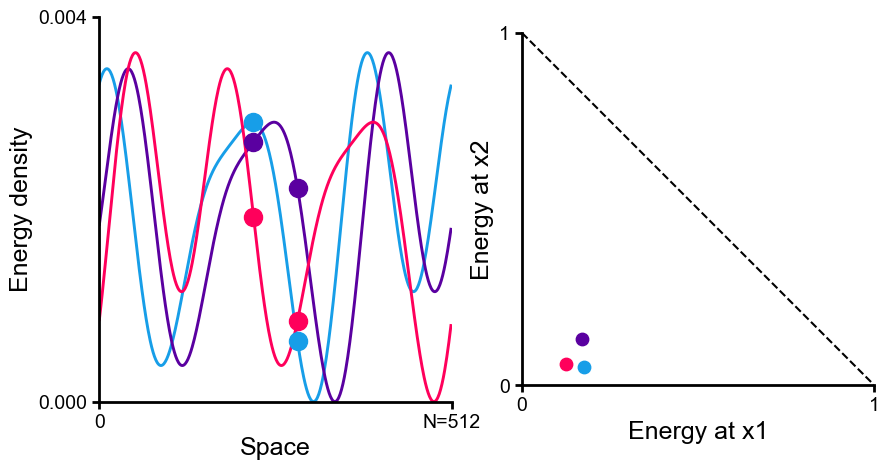

In [2]:
n_objects = 20
num_nyquist_samples = 8
objects = np.array([generate_random_object('delta') for i in range(n_objects)])

# generate random convolution kernel
random_kernel = signal_from_params(generate_params_of_random_signal(num_nyquist_samples=num_nyquist_samples))
conv_mat = make_convolutional_encoder(random_kernel)

output_signals = objects @ conv_mat.T 


sampling_indices = (3, 4)
num_to_plot = 3

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
plot_in_spatial_coordinates(ax[0], output_signals[:num_to_plot], sampling_indices=sampling_indices)
plot_in_intensity_coordinates(ax[1], output_signals[:num_to_plot], sampling_indices=sampling_indices, plot_signals_in_different_colors=True)

## Show example objects

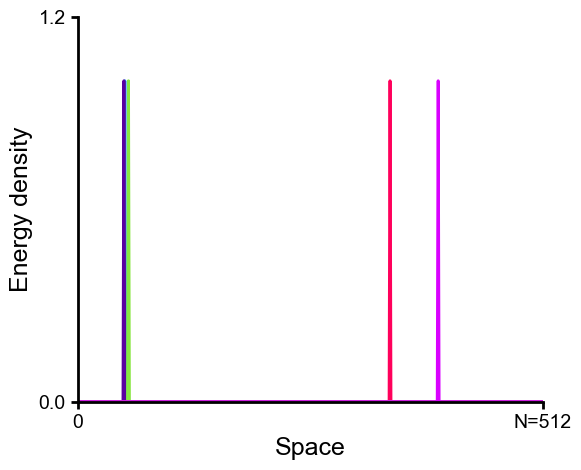

In [3]:
n_objects = 5
objects = np.array([generate_random_object('delta') for i in range(n_objects)])
# objects = np.array([sample_amplitude_object('sinusoid', sin_freq_range=(9, 10)) for i in range(n_objects)])

# plot all the objects
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
plot_in_spatial_coordinates(ax, objects)

## Optimize an encoder based on entropy as a loss function

In [4]:
N_objects = 2000
noise_sigma = 1e-4
num_nyquist_samples = 10
sampling_indices = (1, 2)


objects_fn = lambda : np.array([generate_random_object('delta', num_deltas=1) for i in range(N_objects)])
# objects_fn = lambda : np.array([generate_random_object('delta', num_deltas=5) for i in range(N_objects)])
# objects_fn = lambda : np.array([generate_random_object('pink_noise') for i in range(N_objects)])
# objects_fn = lambda : np.array([generate_random_object('white_noise') for i in range(N_objects)])
# objects_fn = lambda : np.array([generate_random_object('random_amplitude_delta') for i in range(N_objects)])
# objects_fn = lambda : np.array([generate_random_object('random_pairs') for i in range(N_objects)])
# objects_fn = lambda : np.array([generate_random_object('delta_in_some_places') for i in range(N_objects)])
# objects_fn = lambda : np.array([generate_random_object('sinusoid', sin_freq_range=(9, 10)) for i in range(N_objects)])

objects = objects_fn()


initial_kernel = generate_random_signal(num_nyquist_samples=num_nyquist_samples)
initial_params = params_from_signal(initial_kernel)

loss_fn = make_convolutional_forward_model_with_mi_loss(objects, noise_sigma)
optimized_params = run_optimzation(loss_fn, signal_prox_fn, 
                         initial_params, learning_rate=1e-2, learning_rate_decay=0.999, verbose=True,
                         loss_improvement_patience=2000, max_epochs=5000, key=jax.random.PRNGKey(0))
optimized_loss = loss_fn(optimized_params, key=jax.random.PRNGKey(0))

test_objects = objects_fn()
output_signals = conv_forward_model(optimized_params, objects, num_nyquist_samples=num_nyquist_samples)

initial loss -2.947424891070529


Text(0.5, 1.0, 'Object')

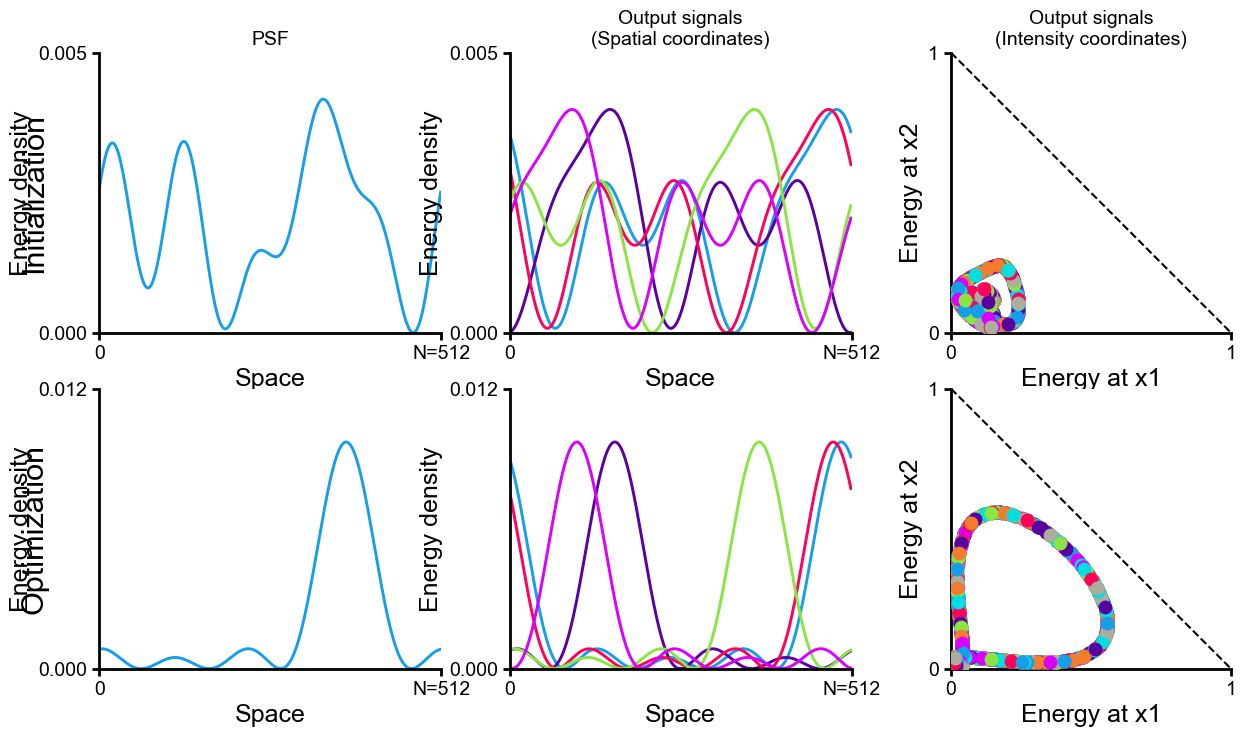

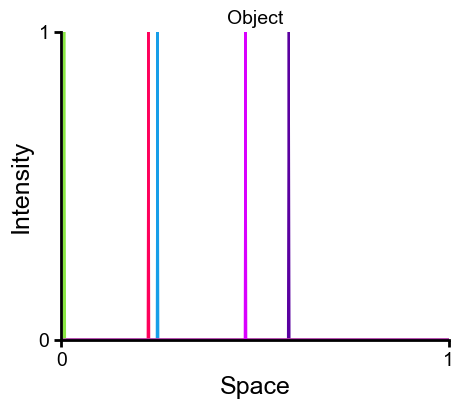

In [8]:
N_objects_to_plot = 5

# plot the initial and optimized convolutional encoders
fig, ax = plt.subplots(2, 3, figsize=(15, 8))

plot_in_spatial_coordinates(ax[0, 0], initial_kernel, show_samples=False)
plot_in_spatial_coordinates(ax[1, 0], signal_from_params(optimized_params), show_samples=False)
ax[0,0].set_title('PSF')


ax[0, 0].text(-0.15, 0.5, 'Initialization', transform=ax[0, 0].transAxes,
            rotation=90, va='center', ha='right', fontsize=22)           
ax[1, 0].text(-0.15, 0.5, 'Optimization', transform=ax[1, 0].transAxes,
            rotation=90, va='center', ha='right', fontsize=22)       

# plot the output signals
plot_in_spatial_coordinates(ax[0, 1], conv_forward_model(initial_params, objects[:N_objects_to_plot], ), show_samples=False)
plot_in_spatial_coordinates(ax[1, 1], conv_forward_model(optimized_params, objects[:N_objects_to_plot]), show_samples=False)
ax[0,1].set_title('Output signals\n(Spatial coordinates)')

# plot the output signals in intensity coordinates
plot_in_intensity_coordinates(ax[0, 2], conv_forward_model(initial_params, objects), plot_signals_in_different_colors=True, sampling_indices=sampling_indices)
plot_in_intensity_coordinates(ax[1, 2], conv_forward_model(optimized_params, objects),  plot_signals_in_different_colors=True, sampling_indices=sampling_indices)

ax[0,2].set_title('Output signals\n(Intensity coordinates)')
# fig.suptitle(f'Best MI: {mutual_information:.2f} bits', fontsize=20)


fig, ax = plt.subplots(1, 1, figsize=(5, 4))
plot_object(ax, objects[:N_objects_to_plot])
ax.set_title('Object')